In [1]:
# Liens ressources complémentaires
# https://docs.edgeimpulse.com/docs/edge-impulse-studio/learning-blocks/object-detection/fomo-object-detection-for-constrained-devices
# https://docs.edgeimpulse.com/docs/tutorials/end-to-end-tutorials/object-detection/detect-objects-using-fomo

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import json

In [3]:
# Composition du dataset :
# Training data : 439 images
# Testing data : 84 images
# Chaque image est de résolution 96x96 en grayscale (9216 pixels)
    
X_train = np.load("ei-beer-vs.-cans-fomo-image-X.npy")
X_train.shape

(439, 9216)

[[0.25805882 0.23727843 0.2305647  ... 0.39081568 0.32227844 0.27117255]
 [0.26198038 0.24512157 0.23448628 ... 0.40258038 0.3262     0.27509412]
 [0.25805882 0.25688627 0.24115686 ... 0.4159647  0.3328706  0.27784315]
 ...
 [0.25760785 0.25760785 0.25368628 ... 0.19267058 0.18874902 0.18252549]
 [0.238      0.23015687 0.24584314 ... 0.18689412 0.18734118 0.1882353 ]
 [0.2262353  0.2262353  0.21839216 ... 0.18454902 0.18981177 0.19187844]]
(96, 96)


[[[0.25805882 0.25805882 0.25805882]
  [0.23727843 0.23727843 0.23727843]
  [0.2305647  0.2305647  0.2305647 ]
  ...
  [0.39081568 0.39081568 0.39081568]
  [0.32227844 0.32227844 0.32227844]
  [0.27117255 0.27117255 0.27117255]]

 [[0.26198038 0.26198038 0.26198038]
  [0.24512157 0.24512157 0.24512157]
  [0.23448628 0.23448628 0.23448628]
  ...
  [0.40258038 0.40258038 0.40258038]
  [0.3262     0.3262     0.3262    ]
  [0.27509412 0.27509412 0.27509412]]

 [[0.25805882 0.25805882 0.25805882]
  [0.25688627 0.25688627 0.25688627]
  [0.241156

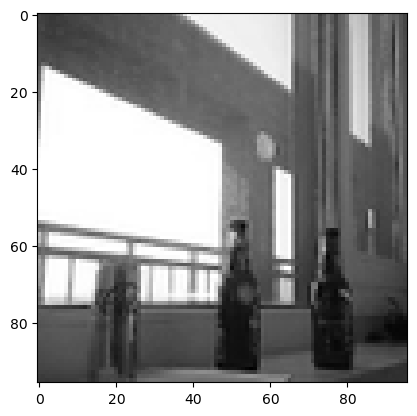

In [4]:
# Exploration des données de training
# On caste l'image dans deux formats : un en grayscale pour l'usage de l'inférence IA, l'autre en RGB pour les affichages
pic = np.array(tf.reshape(X_train[0], [96, 96]))
rgbpic = cv2.cvtColor(pic, cv2.COLOR_GRAY2RGB)
print(pic)
print(pic.shape)
print("\n")
print(rgbpic)
print(rgbpic.shape)
plt.imshow(rgbpic, cmap='gray')

[[-62 -67 -69 ... -28 -45 -58]
 [-61 -65 -68 ... -25 -44 -57]
 [-62 -62 -66 ... -21 -43 -57]
 ...
 [-62 -62 -63 ... -78 -79 -81]
 [-67 -69 -65 ... -80 -80 -80]
 [-70 -70 -72 ... -80 -79 -79]]


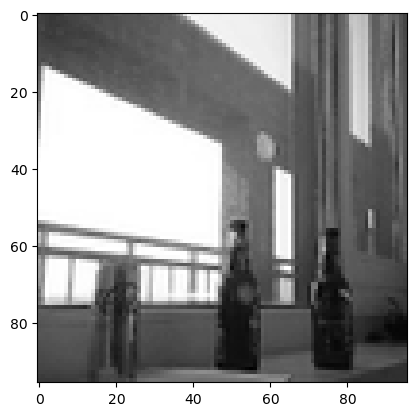

In [5]:
# On redresse l'image grayscale pour qu'elle soit au format d'entrée du modèle FOMO (int8, valeur de 0 à 255)
pic = np.int8(pic*255-128)
print(pic)
plt.imshow(pic, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[{'label': 1, 'x': 46, 'y': 53, 'w': 11, 'h': 42}, {'label': 1, 'x': 70, 'y': 54, 'w': 12, 'h': 40}, {'label': 2, 'x': 14, 'y': 62, 'w': 12, 'h': 34}]


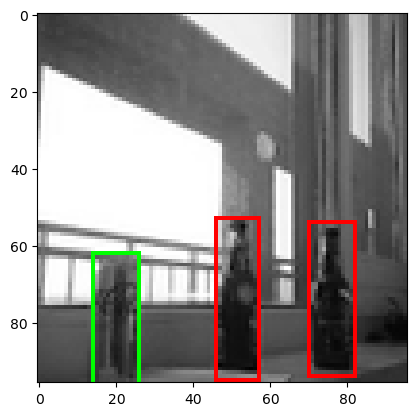

In [6]:
#Tracé des bbox d'entrainement pour la première image du dataset

f = open("ei-beer-vs.-cans-fomo-image-y.json", "r")
y_train = json.load(f)
f.close()

bbx = y_train["samples"][0]["boundingBoxes"]
print(bbx)

for i in range(len(bbx)):
    if bbx[i]['label'] == 1:
        bbxpic = cv2.rectangle(rgbpic, (bbx[i]['x'], bbx[i]['y']), (bbx[i]['x']+bbx[i]['w'], bbx[i]['y']+bbx[i]['h']), (250,0,0))
    if bbx[i]['label'] == 2:
        bbxpic = cv2.rectangle(rgbpic, (bbx[i]['x'], bbx[i]['y']), (bbx[i]['x']+bbx[i]['w'], bbx[i]['y']+bbx[i]['h']), (0,250,0))
    
plt.imshow(bbxpic, cmap='gray')

In [7]:
# Ouverture du modèle au format TensorFlow Lite et inférence de la première image du dataset

interpreter = tf.lite.Interpreter(model_path="ei-beer-vs.-cans-fomo-object-detection-tensorflow-lite-int8-quantized-model.lite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = tf.reshape(pic, [1, 96, 96, 1]) # np.array(np.random.random_sample(input_shape), dtype=np.float32)

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
output_print = (output_data+128)
print(output_data)
print(output_data.shape)

[[[[ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]]

  [[ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]]

  [[ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]]

  [[ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]
   [ 127 -128 -128]]

  [[ 127 -128 -128]
   [ 127 -12

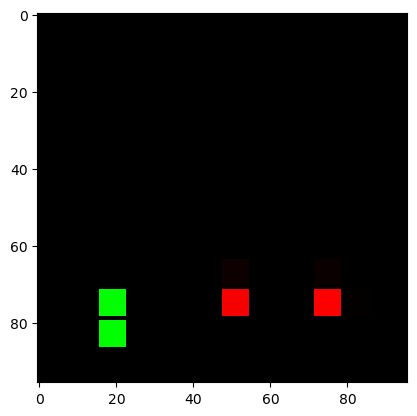

In [8]:
# Affichage des réponses du modèle FOMO : dans un bloc de 8x8 se trouve un objet de classe 1 ou 2 ou non

img = np.zeros((96,96,3), np.uint8)

for i in range(np.shape(output_print)[1]):
    for j in range(np.shape(output_print)[2]):
        img[8*i:8*(i+1)-1, 8*j:8*(j+1)-1, 0] += output_print[0][i][j][1]
        img[8*i:8*(i+1)-1, 8*j:8*(j+1)-1, 1] += output_print[0][i][j][2]

plt.imshow(img)

In [9]:
# Génération des sorties de FOMO pour toutes les images du dataset d'entraînement
output_file = []

for i in X_train:
    pic = np.array(tf.reshape(i, [96, 96]))
    pic = np.int8(pic*255-128)
    input_data = tf.reshape(pic, [1, 96, 96, 1])
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_file.append(tf.reshape(output_data, [432]))

output_file = np.array(output_file)
print(output_file.shape)
np.save("fomo-output-X.npy", output_file)

(439, 432)
